Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 57117417.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1489434.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3027489.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2462899.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Training with initialization method: xavier
xavier - Epoch 1, Train Loss: 0.3315, Test Loss: 0.1750, Test Acc: 0.95
xavier - Epoch 2, Train Loss: 0.1436, Test Loss: 0.1179, Test Acc: 0.97
xavier - Epoch 3, Train Loss: 0.1037, Test Loss: 0.1155, Test Acc: 0.97
xavier - Epoch 4, Train Loss: 0.0814, Test Loss: 0.0893, Test Acc: 0.97
xavier - Epoch 5, Train Loss: 0.0661, Test Loss: 0.1035, Test Acc: 0.97
xavier - Epoch 6, Train Loss: 0.0558, Test Loss: 0.1073, Test Acc: 0.97
xavier - Epoch 7, Train Loss: 0.0475, Test Loss: 0.0854, Test Acc: 0.97
xavier - Epoch 8, Train Loss: 0.0405, Test Loss: 0.0858, Test Acc: 0.97
xavier - Epoch 9, Train Loss: 0.0355, Test Loss: 0.0779, Test Acc: 0.98
xavier - Epoch 10, Train Loss: 0.0311, Test Loss: 0.0764, Test Acc: 0.98

Training with initialization method: he
he - Epoch 1, Train Loss: 0.3332, Test Loss: 0.1669, Test Acc: 0.95
he - Epoch 2, Train Loss: 0.1458, Test Loss: 0.132

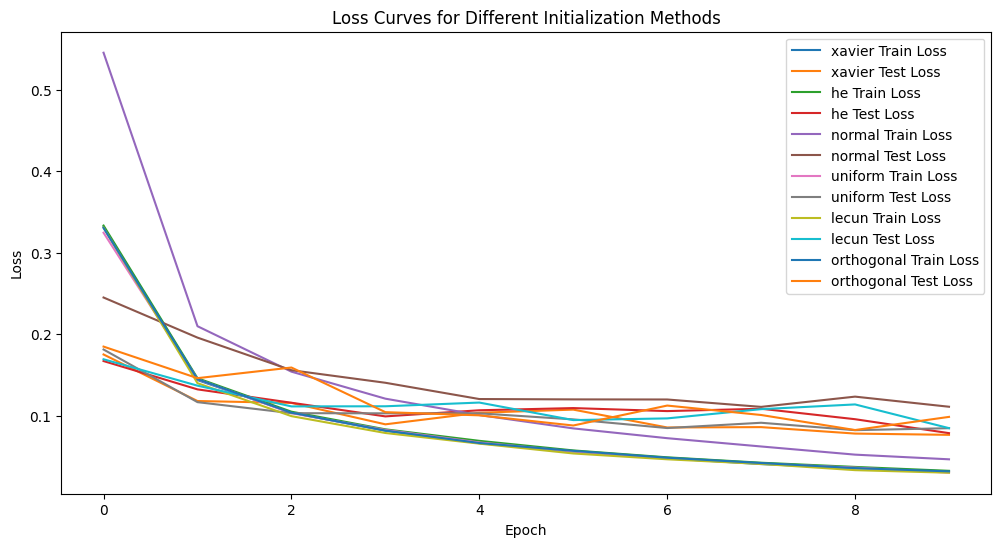

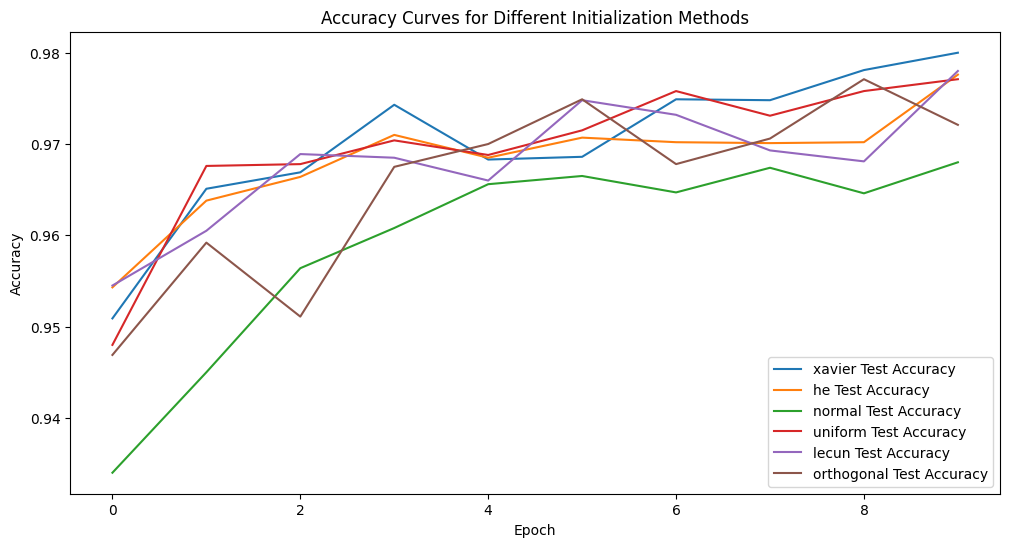

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree, init_method='xavier'):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        self.init_method = init_method
        self.initialize_weights()
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def initialize_weights(self):
        if self.init_method == 'xavier':
            nn.init.xavier_normal_(self.cheby_coeffs)
        elif self.init_method == 'he':
            nn.init.kaiming_normal_(self.cheby_coeffs, nonlinearity='relu')
        elif self.init_method == 'normal':
            nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1.0)
        elif self.init_method == 'uniform':
            nn.init.uniform_(self.cheby_coeffs, a=-0.1, b=0.1)
        elif self.init_method == 'lecun':
            nn.init.kaiming_normal_(self.cheby_coeffs, nonlinearity='linear')
        elif self.init_method == 'orthogonal':
            nn.init.orthogonal_(self.cheby_coeffs)
        else:
            raise ValueError("Unknown initialization method")

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), 2*x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

class ChebyshevKANModel(nn.Module):
    def __init__(self, degree, hidden_dim, init_method='xavier'):
        super(ChebyshevKANModel, self).__init__()
        self.chebyshevkan1 = ChebyshevKANLayer(28*28, hidden_dim, degree, init_method)
        self.layernorm1 = nn.LayerNorm(hidden_dim)
        self.chebyshevkan2 = ChebyshevKANLayer(hidden_dim, 10, degree, init_method)
        self.layernorm2 = nn.LayerNorm(10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.chebyshevkan1(x)
        x = self.layernorm1(x)
        x = self.chebyshevkan2(x)
        x = self.layernorm2(x)
        return x

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# Data loading and transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Best parameters found
best_params = {'lr': 0.0005, 'hidden_dim': 64, 'batch_size': 4, 'degree': 4}
epochs = 10

init_methods = ['xavier', 'he', 'normal', 'uniform', 'lecun', 'orthogonal']
final_accuracies = {}
loss_curves = {}
accuracy_curves = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for init_method in init_methods:
    print(f'\nTraining with initialization method: {init_method}')
    model = ChebyshevKANModel(degree=best_params['degree'], hidden_dim=best_params['hidden_dim'], init_method=init_method).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = validate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'{init_method} - Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')
    
    final_accuracies[init_method] = test_accuracies[-1]
    loss_curves[init_method] = (train_losses, test_losses)
    accuracy_curves[init_method] = test_accuracies

plt.figure(figsize=(12, 6))

for init_method in init_methods:
    train_losses, test_losses = loss_curves[init_method]
    plt.plot(train_losses, label=f'{init_method} Train Loss')
    plt.plot(test_losses, label=f'{init_method} Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Initialization Methods')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

for init_method in init_methods:
    test_accuracies = accuracy_curves[init_method]
    plt.plot(test_accuracies, label=f'{init_method} Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves for Different Initialization Methods')
plt.legend()
plt.show()
